# Sparkify Capstone Project 

# Imports

In [1]:
# Spark
import pyspark
from pyspark import keyword_only
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.types import StringType, IntegerType, FloatType, DateType, LongType
from pyspark.sql.window import Window

# Other Data Libraries
import pandas as pd
import datetime
import numpy as np
import seaborn as sns
import re
import matplotlib.pyplot as plt

# ETL Pipeline Libraries
from pyspark.ml.pipeline import Transformer, Pipeline
from pyspark.ml.param.shared import HasInputCol, HasOutputCol, Param, Params, TypeConverters
from pyspark.ml.util import DefaultParamsReadable, DefaultParamsWritable

#Machine Learning Libraries
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.regression import GeneralizedLinearRegression
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Setup

In [2]:
#Notebook Setup
%matplotlib inline
sns.set()
colors = sns.color_palette()

In [3]:
# Spark Setup
spark = SparkSession.builder \
                    .master("local") \
                    .appName("CapstoneProject") \
                    .getOrCreate()

In [4]:
#Get Spark Context
sc = spark.sparkContext

# ETL
This section will Load and Clean the Dataset, checking for invalid or missing data.

In [5]:
#Reading Data
sparkify = spark.read.json('mini_sparkify_event_data.json')

In [6]:
#Number of Rows
n_rows = sparkify.count()
n_rows

286500

In [7]:
#Show Schema
sparkify.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
#Get one row as example
sparkify.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

## Column `userId`

Let's account for missing values in `userId`. 
To do that, we should create and `accumulator`

In [9]:
#Create Accumulator
missing_userIds = sc.accumulator(0)

#Define Accumulation Function
def missing_Id():
    global missing_userIds
    missing_userIds += 1

count_missing = F.udf(lambda x: x if x.isdigit() else missing_Id())

#Run Function
sparkify.select('userId').withColumn('userId', count_missing('userId')).collect()

#Log
missing_percentage = 100*missing_userIds.value/n_rows
print(f'{missing_userIds.value} userIds are missing')
print(f'That is {missing_percentage:.2f}% of the rows')

8346 userIds are missing
That is 2.91% of the rows


Now, let's drop them

In [10]:
sparkify = sparkify.where("userId != ''")

## Timestamp Columns

We see that the column `ts` and `registration` are in *microseconds*.

Let's convert them to *seconds* and then to complete date format

In [11]:
#Date Format
fmt = 'yyyy-MM-dd HH:mm:ss'

#Convert from miliseconds to seconds
ts_converter = F.udf(lambda x: x/1000, FloatType())

#Do the conversion
sparkify = sparkify.withColumn('ts', ts_converter('ts'))\
                   .withColumn('ts', F.from_unixtime('ts', format = fmt))\
                   .withColumn('ts', F.to_timestamp('ts'))\
                   .withColumn('registration', ts_converter('registration'))\
                   .withColumn('registration', F.from_unixtime('registration', format = fmt))\
                   .withColumn('registration', F.to_timestamp('registration'))

Verifying if the date is properly formatted

In [12]:
sparkify.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=datetime.datetime(2018, 9, 28, 19, 21, 52), sessionId=29, song='Rockpools', status=200, ts=datetime.datetime(2018, 9, 30, 21, 2, 8), userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30')]

# Exploratory Data Analysis

## Features Overview

Let's check how many unique users we have

In [13]:
sparkify.select(F.countDistinct("userId")).show()

+----------------------+
|count(DISTINCT userId)|
+----------------------+
|                   225|
+----------------------+



Now Let's see how the columns `auth`, `method`, `page`, `level`, `gender`, `status` and `userAgent` look like:

To do that, I will define the function `value_counts` (Similar to Pandas' Series method)

In [14]:
def value_counts(df, column):
    return df.groupby(column).count().orderBy('count', ascending = False)

In [15]:
auth = value_counts(sparkify, 'auth')
auth.show()

+---------+------+
|     auth| count|
+---------+------+
|Logged In|278102|
|Cancelled|    52|
+---------+------+



In [16]:
method = value_counts(sparkify, 'method')
method.show()

+------+------+
|method| count|
+------+------+
|   PUT|257818|
|   GET| 20336|
+------+------+



In [17]:
page = value_counts(sparkify, 'page')
page.show()

+--------------------+------+
|                page| count|
+--------------------+------+
|            NextSong|228108|
|           Thumbs Up| 12551|
|                Home| 10082|
|     Add to Playlist|  6526|
|          Add Friend|  4277|
|         Roll Advert|  3933|
|              Logout|  3226|
|         Thumbs Down|  2546|
|           Downgrade|  2055|
|            Settings|  1514|
|                Help|  1454|
|             Upgrade|   499|
|               About|   495|
|       Save Settings|   310|
|               Error|   252|
|      Submit Upgrade|   159|
|    Submit Downgrade|    63|
|              Cancel|    52|
|Cancellation Conf...|    52|
+--------------------+------+



In [18]:
level = value_counts(sparkify, 'level')
level.show()

+-----+------+
|level| count|
+-----+------+
| paid|222433|
| free| 55721|
+-----+------+



In [19]:
gender = value_counts(sparkify, 'gender')
gender.show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



In [20]:
userAgent = value_counts(sparkify, 'userAgent')
userAgent.show()

+--------------------+-----+
|           userAgent|count|
+--------------------+-----+
|"Mozilla/5.0 (Win...|22751|
|"Mozilla/5.0 (Mac...|19611|
|"Mozilla/5.0 (Mac...|18448|
|"Mozilla/5.0 (Mac...|17348|
|Mozilla/5.0 (Wind...|16700|
|"Mozilla/5.0 (Win...|15395|
|"Mozilla/5.0 (Win...|14598|
|Mozilla/5.0 (Maci...|10300|
|"Mozilla/5.0 (iPa...| 8912|
|Mozilla/5.0 (comp...| 8624|
|"Mozilla/5.0 (Mac...| 8094|
|"Mozilla/5.0 (Win...| 7923|
|"Mozilla/5.0 (Mac...| 7906|
|"Mozilla/5.0 (Win...| 7624|
|"Mozilla/5.0 (iPh...| 6417|
|Mozilla/5.0 (Wind...| 5989|
|"Mozilla/5.0 (Mac...| 5716|
|"Mozilla/5.0 (Win...| 5238|
|"Mozilla/5.0 (Win...| 4917|
|Mozilla/5.0 (Wind...| 4663|
+--------------------+-----+
only showing top 20 rows



In [21]:
status = value_counts(sparkify, 'status')
status.show()

+------+------+
|status| count|
+------+------+
|   200|254718|
|   307| 23184|
|   404|   252|
+------+------+



## Defining Churn

Let's create a column `Churn` to use as the label for your model.

To do that, I am going to transform the DataFrame from **one-row-one-song** to **one-row-one-userId** with the `make_pivot` function below. 

Then, I'll rename the `Cancellation Confirmation` column as `Churn`

In [22]:
def make_pivot(df, pivot_col, agg_func = 'count', fill_na = False, fill_value = 0):
    
    #GroupBy Pivot Column
    group = df.select('userId',pivot_col).groupby('userId')
    
    #Make Pivot Table and Aggregate it with 'agg_func'
    pivot = group.pivot(pivot_col).agg({pivot_col:agg_func})
    
    #If True, fill null values with fill_value
    if fill_na:
        pivot = pivot.fillna(fill_value)
        
    return pivot

In [23]:
#Pivot Transformation
page_pivot = make_pivot(sparkify, 'page', fill_na=True)

#Renaming column
page_pivot = page_pivot.withColumnRenamed('Cancellation Confirmation','Churn')

I am gonna do something similar for the `auth` column, since it contains information about how many times the user logged in.

In [24]:
#Pivot Transformation
auth_pivot = make_pivot(sparkify, 'auth')

#Dropping Cancelled column
auth_pivot = auth_pivot.drop('Cancelled')

Next, for the `method` column:

In [25]:
#Pivot Transformation
method_pivot = make_pivot(sparkify, 'method')

Finally, for the `status` column:

In [26]:
#Pivot Transformation
status_pivot = make_pivot(sparkify, 'status', fill_na=True)

**NOTE**: 
1. I'll not include the `level` feature, since the `Submit Upgrade` and `Submit Downgrade` from `page_pivot` already capture well the user's level
1. Also, `userAgent` contains too many values to encode, so it'll be left out of the analysis

## Explore Count Features

Since we are dealing with lots of *count variables*, I am gonna define a `histogram` function to make visualizations simpler:

In [27]:
def histogram(df):
    
    df = df.toPandas()
    columns = df.columns[1:]
    columns = columns.drop('Churn')
    for col in columns:
        zero, ones = df.hist(column = col, by = 'Churn', sharex=True, sharey=True)

        #Not Churn Plot Properties
        zero.set_ylabel("User Count")
        zero.set_xlabel(f"{col} Count")
        zero.set_title("Not Churn")

        #Churn Plot Properties
        ones.set_xlabel(f"{col} Count")
        ones.set_title("Churn")
        for rect in ones.patches: #Change color
            rect.set_color(colors[1])

        plt.show()

**According to Page**

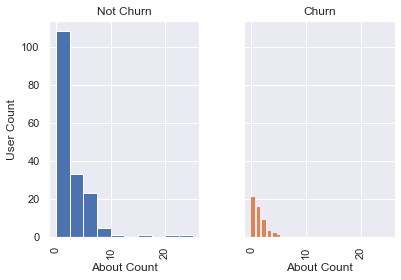

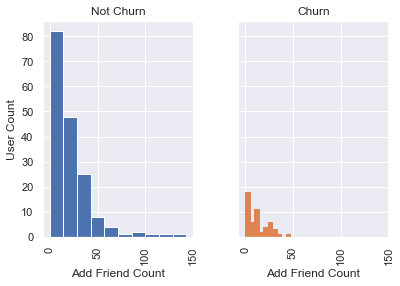

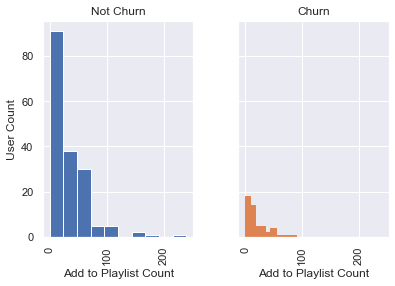

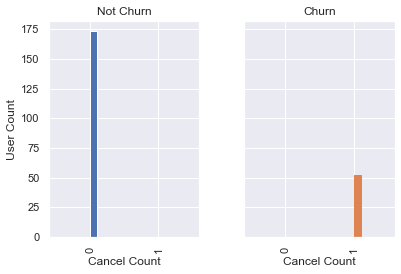

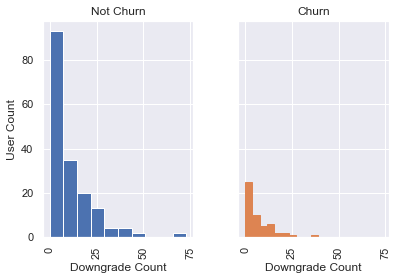

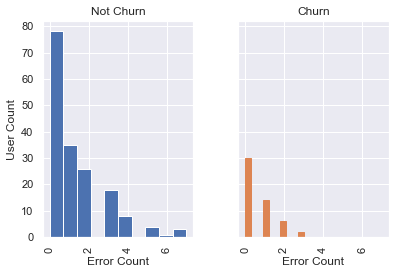

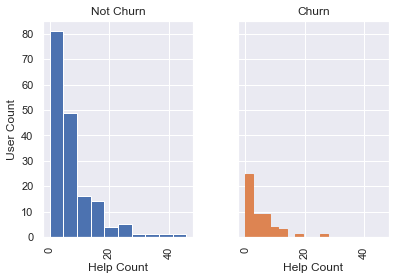

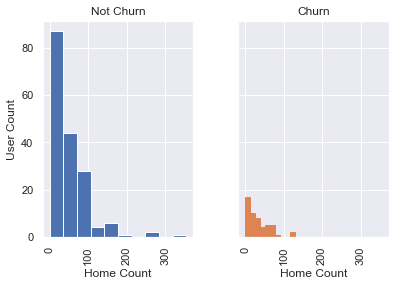

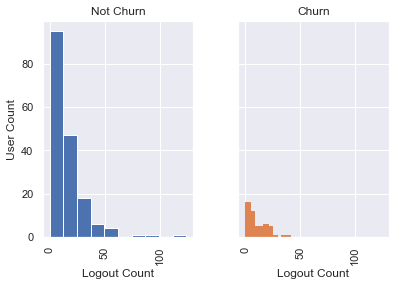

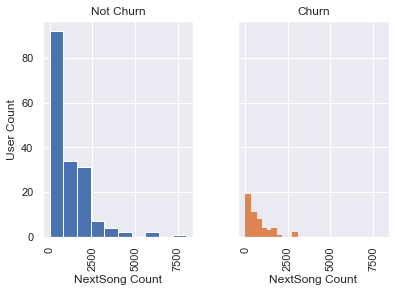

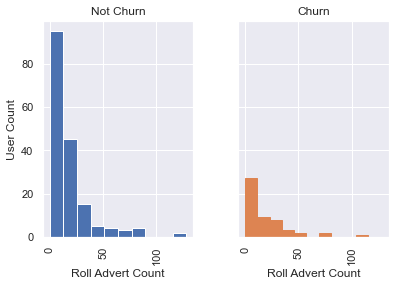

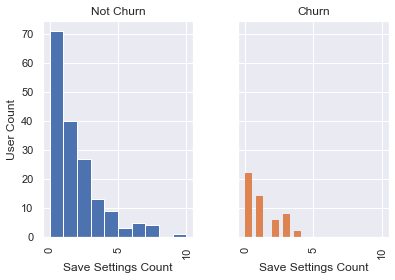

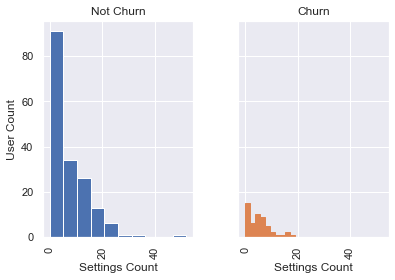

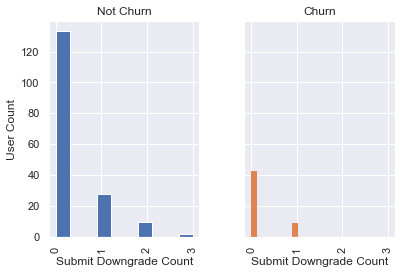

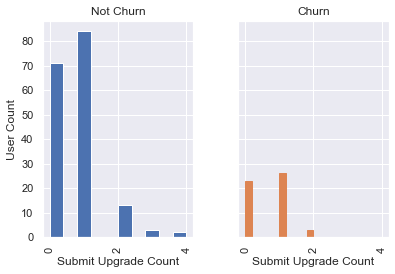

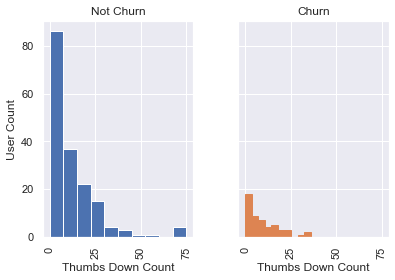

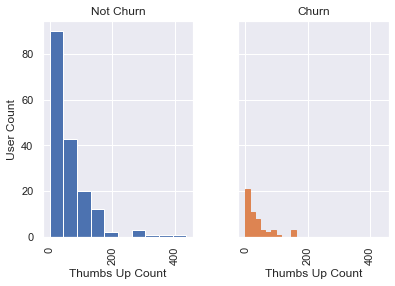

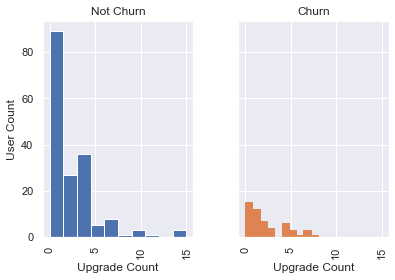

In [28]:
histogram(page_pivot)

Note that `Cancel` expresses the same information as `Churn`, so it must be dropped so that the model doesn't overfit

**According to Auth**

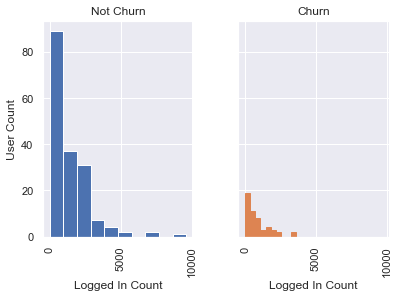

In [29]:
df = page_pivot.select('userId','Churn') 
df = df.join(auth_pivot, on = ['userId'], how = 'left')
histogram(df)

**According to Method**

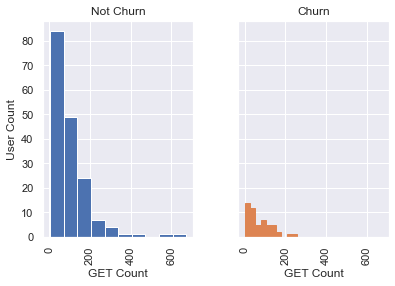

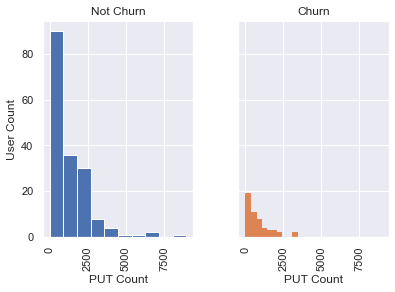

In [30]:
df = page_pivot.select('userId','Churn') 
df = df.join(method_pivot, on = ['userId'], how = 'left')
histogram(df)

**According to Status**

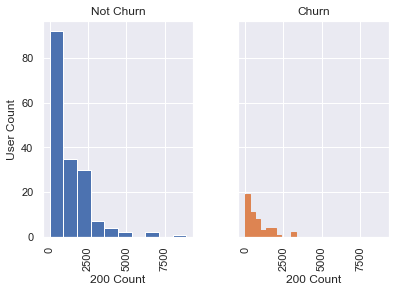

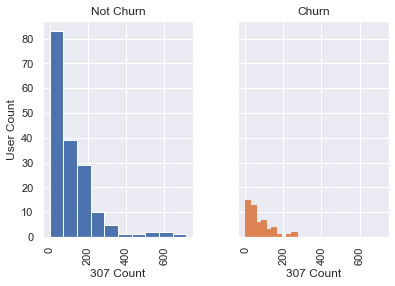

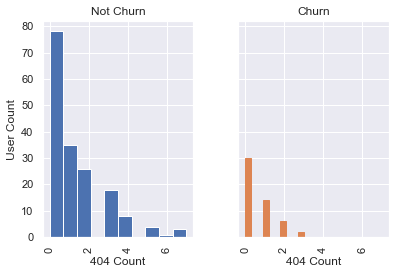

In [31]:
df = page_pivot.select('userId','Churn') 
df = df.join(status_pivot, on = ['userId'], how = 'left')
histogram(df)

**Count Variables Conclusion**

From the plots wee see that the biggest differences between the users who Churned and those who didn't are the `counts`, but all plots seem to have a *decreasing exponential distribution*

## Explore Binary Features
In this case, only **Gender** will be analyzed.

<AxesSubplot:xlabel='Gender', ylabel='User Count'>

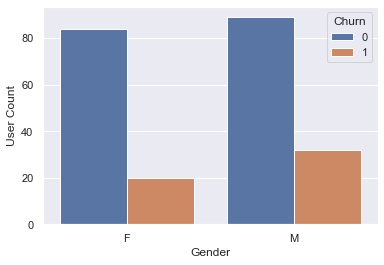

In [32]:
gend = sparkify.select('userId', 'Gender')\
                 .dropDuplicates()

df = page_pivot.select('userId','Churn')
df = df.join(gend, on = ['userId'], how = 'left')

df = df.groupBy('Gender','Churn').count()
df = df.withColumnRenamed('count', 'User Count').toPandas()

sns.barplot(x = 'Gender', y = 'User Count', hue = 'Churn', data = df)

Now, if you remember from the `value_counts` analysis:

In [33]:
gender.show()

+------+------+
|gender| count|
+------+------+
|     F|154578|
|     M|123576|
+------+------+



There are fewer women using **sparkify**, but they use the app way more often and are less likely to `Churn` compared to men.

## Explore Time Features

Now we're going to evaluate the age and the time between sessions for each `userId`.

To do that, we need to use a `Window`

In [34]:
window = Window.partitionBy('userId').orderBy('ts')

In [35]:
tbs = sparkify.withColumn('previous_session', F.lag('ts',1).over(window))\
              .withColumn('tbs', F.col('ts').cast(LongType()) - F.col('previous_session').cast(LongType()))\
              .fillna(0, subset = ['tbs'])\
              .groupBy('userId').agg(F.max('tbs'), F.avg('tbs'))

Now joining with the `page_pivot` to get information about `Churn`

In [36]:
df = page_pivot.select('userId','Churn')
df = df.join(tbs, on = ['userId'], how = 'left')

And next, plotting

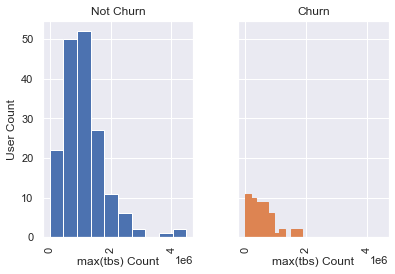

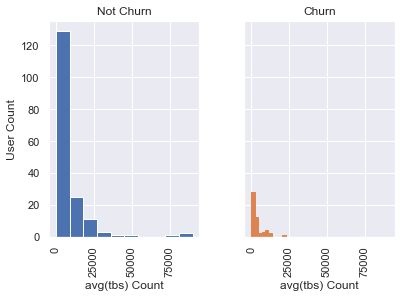

In [37]:
histogram(df)

We can see that the `max time between sessions` and the `average time between sessions distributions` are different for users who `Churned` and those who didn't.

Thus, time features can make the model more powerful and are going to be included in the Pipeline

# Feature Engineering

In here I am going to build the entire ETL Pipeline. 

To do that, I will define multipe transformations:

1. **DropNullId**: Responsible for dropping the null Ids
2. **GenderEncoder**: Responsible for encoding Females as 1 and Males as 0
3. **TimeFeaturesTransform**: Responsible for cleaning the Time Features
4. **PivotTransform**: Responsible for building the EDA's pivot tables
5. **GroupByTransform**: Responsible for building the EDA's groupby tables
6. **JoinTransform**: Responsible for joining all the transformations together

In [38]:
class DropNullId(Transformer):
    
    def _transform(self, dataset):
        return dataset.where("userId != ''")

class GenderEncoder(Transformer):
    
    def _transform(self, dataset):
        
        encode = F.udf(lambda x: 1 if x == 'F' else 0, IntegerType())
        
        return dataset.withColumn('gender', encode('gender'))
    
class TimeFeaturesTransform(Transformer):
    
    def _transform(self, dataset):
        #Date Format
        fmt = 'yyyy-MM-dd HH:mm:ss'

        #Convert from miliseconds to seconds
        ts_converter = F.udf(lambda x: x/1000, FloatType())

        #Do the conversion
        dataset = dataset.withColumn('ts', ts_converter('ts'))\
                         .withColumn('ts', F.from_unixtime('ts', format = fmt))\
                         .withColumn('ts', F.to_timestamp('ts'))\
                         .withColumn('registration', ts_converter('registration'))\
                         .withColumn('registration', F.from_unixtime('registration', format = fmt))\
                         .withColumn('registration', F.to_timestamp('registration'))
        
        #Time Between Sessions
        window = Window.partitionBy('userId').orderBy('ts')
        
        dataset = dataset.withColumn('previous_session', F.lag('ts',1).over(window))\
                         .withColumn('tbs', F.col('ts').cast(LongType()) - F.col('previous_session').cast(LongType()))\
                         .fillna(0, subset = ['tbs'])
        
        return dataset
    
class PivotTransform(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    
    #Credits to:
    #https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    
    drop_columns = Param(Params._dummy(), "drop_columns", "columns to drop after pivot",
                          typeConverter=TypeConverters.toListString)
    
    pivot_col = Param(Params._dummy(), "pivot_col", "Column to pivot",
                     typeConverter=TypeConverters.toString)
    
    @keyword_only
    def __init__(self, pivot_col, drop_columns = None):
        
        super(PivotTransform, self).__init__()
        
        #Pivot Column Parameter
        self.pivot_col = Param(self, "pivot_col", "Column to pivot")
        
        #Drop Columns Parameter
        self.drop_columns = Param(self, "drop_columns", "columns to drop after pivot")
        self._setDefault(drop_columns=[])
        
        #Set Parameters
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, pivot_col, drop_columns = None):
        
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    #Drop Column Methods
    def setDropColumns(self, value):
        return self._set(drop_columns=value)

    def getDropColumns(self):
        return self.getOrDefault(self.drop_columns)
    
    #Pivot Methods
    def setPivotColumn(self, value):
        return self._set(pivot_col=value)

    def getPivotColumn(self):
        return self.getOrDefault(self.pivot_col)
    
    def _transform(self, dataset):
        
        pivot_col = self.getPivotColumn()
        drop_columns = self.getDropColumns()
        
        #GroupBy Pivot Column
        group = dataset.select('userId',pivot_col).groupby('userId')

        #Make Pivot Table and Aggregate it with 'agg_func'
        pivot = group.pivot(pivot_col).agg({pivot_col:'count'})

        #Fill null values with zero
        pivot = pivot.fillna(0)
        
        #Drop Columns From Pivot
        pivot = pivot.drop(*drop_columns)
        
        #Convert userId to int
        pivot = pivot.withColumn('userId', F.col('userId').cast(IntegerType()))
        
        return pivot

class GroupByTransform(Transformer, DefaultParamsReadable, DefaultParamsWritable):
    
    #Credits to:
    #https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    
    agg_funcs = Param(Params._dummy(), "agg_funcs", "Functions resposible for the aggregations",
                     typeConverter=TypeConverters.toList)
    
    @keyword_only
    def __init__(self, agg_funcs):
        
        super(GroupByTransform, self).__init__()
        
        #Pivot Column Parameter
        self.agg_funcs = Param(self, "agg_funcs", "Functions resposible for the aggregations")
        
        #Set Parameters
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, agg_funcs):
        
        kwargs = self._input_kwargs
        return self._set(**kwargs)
    
    #Agg Funcs Methods
    def setAggFuncs(self, value):
        return self._set(agg_funcs=value)

    def getAggFuncs(self):
        return self.getOrDefault(self.agg_funcs)
    
    def _transform(self, dataset):
        
        agg_funcs = self.getAggFuncs()
        
        #GroupBy Pivot Column
        group = dataset.groupby('userId').agg(*agg_funcs)
        
        return group
    
class JoinTransformers(Transformer,DefaultParamsReadable, DefaultParamsWritable):
        
    #Credits to:
    #https://stackoverflow.com/questions/32331848/create-a-custom-transformer-in-pyspark-ml
    
    transformations = Param(Params._dummy(), "transformations", "List of Transformations",
                          typeConverter=TypeConverters.toList)
    
    @keyword_only
    def __init__(self, transformations = None):
        
        super(JoinTransformers, self).__init__()
        
        #Transformations
        self.transformations = Param(self, "transformations", "List of Transformations")
        self._setDefault(transformations=[])
        
        #Set Parameters
        kwargs = self._input_kwargs
        self.setParams(**kwargs)

    @keyword_only
    def setParams(self, transformations = None):
        
        kwargs = self._input_kwargs
        return self._set(**kwargs)

    def setTransformations(self, value):
        return self._set(transformations=value)

    def getTransformations(self):
        return self.getOrDefault(self.transformations)
    
    def _transform(self, dataset):
        
        transformations = self.getTransformations()
        
        Transformed = []
        for trans in transformations:
            Transformed.append(trans.transform(dataset))
        
        base = Transformed[0]
        for trans in Transformed[1:]:
            base = base.join(trans, on = ['userId'], how = 'left')
        
        return base

In [39]:
#Reading Data
sparkify = spark.read.json('mini_sparkify_event_data.json')

In [40]:
#Basic Processing
drop_null_id = DropNullId()
time_features = TimeFeaturesTransform()
encode_gender = GenderEncoder()

#Pivots
page_pivot = PivotTransform(pivot_col='page', drop_columns=['Cancel'])
auth_pivot = PivotTransform(pivot_col='auth', drop_columns=['Cancelled'])
status_pivot = PivotTransform(pivot_col='status')
method_pivot = PivotTransform(pivot_col='method')

#GroupBys
tbs_groupby = GroupByTransform(agg_funcs=[F.max('tbs'), F.avg('tbs')])
gender_groupby = GroupByTransform(agg_funcs=[F.max('gender')])

#Join Transformations
transfs = JoinTransformers(transformations=[page_pivot, auth_pivot, status_pivot,
                                            method_pivot, tbs_groupby, gender_groupby])

#ETL Pipeline
stages = [drop_null_id, time_features, encode_gender, transfs]
ETLpipe = Pipeline(stages=stages)

#Transform Data
model = ETLpipe.fit(sparkify)
sparkify = model.transform(sparkify)
sparkify = sparkify.withColumnRenamed('Cancellation Confirmation', 'label')

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

## TrainTestSplit

In [41]:
#Since the Data is unbalanced, I am gonna do a Stratified Split
#Credits to: https://stackoverflow.com/questions/47637760/stratified-sampling-with-pyspark

# split dataframes between 0s and 1s
zeros = sparkify.filter('label == 0')
ones = sparkify.filter('label == 1')

# split datasets into training and testing
train0, test0 = zeros.randomSplit([0.8,0.2], seed=2021)
train1, test1 = ones.randomSplit([0.8,0.2], seed=2021)

# put them back together
train = train0.union(train1)
test = test0.union(test1)

Now verifying if the splits were done correctly

In [42]:
train.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|  146|
|    1|   46|
+-----+-----+



In [43]:
test.groupBy('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|   27|
|    1|    6|
+-----+-----+



All good, we can proceed !!

## Pipelines
Since we have a binary classification problem, I am going to use `LogisticRegression` and `RandomForest`

In [44]:
#InputCols
inputCols = ['About', 'Add Friend', 'Add to Playlist', 'Downgrade',
             'Error', 'Help', 'Home', 'Logout', 'NextSong','Roll Advert',
             'Save Settings','Settings','Submit Downgrade','Submit Upgrade',
             'Thumbs Down', 'Thumbs Up', 'Upgrade', 'Logged In', '200',
             '307', '404', 'GET', 'PUT', 'max(tbs)', 'avg(tbs)', 'max(gender)']

In [45]:
#Vector Assembler
vec = VectorAssembler(inputCols = inputCols, outputCol='features')

#Logistic Regression
log = LogisticRegression()
logGrid = ParamGridBuilder().addGrid(log.regParam, [0.1, 0.01]) \
                            .addGrid(log.fitIntercept, [False, True])\
                            .addGrid(log.elasticNetParam, [0.0, 0.5, 1.0])\
                            .build()
log_pipe = Pipeline(stages = [vec, log])

#Random Forest
randfor = RandomForestClassifier()
randGrid = ParamGridBuilder().addGrid(randfor.numTrees, [20, 50, 100]) \
                            .addGrid(randfor.maxDepth, [5, 10, 15])\
                            .build()

rand_pipe = Pipeline(stages = [vec, randfor])

## LogisticRegression

In [46]:
#Fit Best Set of Parameters
logtvs = TrainValidationSplit(estimator=log_pipe,
                               estimatorParamMaps=logGrid,
                               evaluator=BinaryClassificationEvaluator(),
                               trainRatio=0.8)

log_model = logtvs.fit(train)

#Predict Test based on Best Model
preds = log_model.transform(test)

#Evaluate
log_eval = BinaryClassificationEvaluator()
log_res = log_eval.evaluate(preds)

print(f'LogisticRegression AUC: {log_res:.5f}')

LogisticRegression AUC: 0.91975


## RandomForestClassifier

In [47]:
#Fit Best Set of Parameters
randtvs = TrainValidationSplit(estimator=rand_pipe,
                               estimatorParamMaps=randGrid,
                               evaluator=BinaryClassificationEvaluator(),
                               trainRatio=0.8)

rand_model = randtvs.fit(train)

#Predict Test based on Best Model
preds = rand_model.transform(test)

#Evaluate
rand_eval = BinaryClassificationEvaluator()
rand_res = rand_eval.evaluate(preds)

print(f'RandomForest AUC: {rand_res:.5f}')

RandomForest AUC: 0.96605
